# Build the Classifier
This notebook is dedicated to creating classifiers and run classification analyses of interest on neuroimaging data.

Can we accurately classify:
- adults vs. children
- condition within adults
- condition within children

In [1]:
from pandas import DataFrame, Series, read_csv

# Study specific variables
study_home = '/home/camachocm2/Analysis/KidVid_MVPA'
standard_mask = study_home + '/template/MNI152_T1_2mm_brain_mask_KV.nii.gz'
template = study_home + '/template/MNI152_T1_1mm_brain.nii.gz'
sub_data_file = study_home + '/doc/subjectinfo.csv'
preproc_dir = study_home + '/analysis/preproc/betas'
output_dir = study_home + '/analysis/classifier'

condition_data = read_csv(study_home + '/doc/conditionslist.csv')
subject_info = read_csv(sub_data_file)
subject_info.describe()
print()

In [2]:
## Create a conditions list for the feature set
condition_labels = condition_data['labels'].tolist()
subjects_list = subject_info['subjID'].tolist()
age_group_list = subject_info['group'].tolist()
ages_mos_list = subject_info['age_mos'].tolist()
mapdb_temploss_list = subject_info['MAPDB_temploss_std'].tolist()
cbq_angfrust_list = subject_info['CBQ_Anger_Frustration_std'].tolist()
intern_list = subject_info['CBCL_intern_std'].tolist()
extern_list = subject_info['CBCL_extern_std'].tolist()

conditions = condition_data
conditions['subject'] = Series(subjects_list[0], index=conditions.index)
conditions['ageGroup'] = Series(age_group_list[0], index=conditions.index)
conditions['age'] = Series(ages_mos_list[0], index=conditions.index)
conditions['MAPDB'] = Series(mapdb_temploss_list[0], index=conditions.index)
conditions['CBQ'] = Series(cbq_angfrust_list[0], index=conditions.index)
conditions['CBCL_intern'] = Series(intern_list[0], index=conditions.index)
conditions['CBCL_extern'] = Series(extern_list[0], index=conditions.index)

for a in range(1,len(subjects_list)):
    temp=DataFrame()
    temp['labels'] = Series(condition_labels)
    temp['subject'] = Series(subjects_list[a], index=temp.index)
    temp['ageGroup'] = Series(age_group_list[a], index=temp.index)
    temp['age'] = Series(ages_mos_list[a], index=temp.index)
    temp['MAPDB'] = Series(mapdb_temploss_list[a], index=temp.index)
    temp['CBQ'] = Series(cbq_angfrust_list[a], index=temp.index)
    temp['CBCL_intern'] = Series(intern_list[a], index=temp.index)
    temp['CBCL_extern'] = Series(extern_list[a], index=temp.index)
    
    
    conditions = conditions.append(temp, ignore_index=True)

#conditions.to_csv(output_dir + '/featureset_key.csv')
conditions.describe()

,age,MAPDB,CBQ,CBCL_intern,CBCL_extern
count,1224.000000,7.200000e+02,7.200000e+02,7.200000e+02,7.200000e+02
mean,186.007843,-3.333353e-12,-3.333294e-12,3.333346e-12,3.333339e-12
std,118.706330,1.000695e+00,1.000695e+00,1.000695e+00,1.000695e+00
min,58.000000,-1.568304e+00,-2.255473e+00,-8.916857e-01,-8.826855e-01
25%,84.500000,-9.273081e-01,-6.841020e-01,-7.212999e-01,-7.182100e-01
50%,122.100000,-9.401280e-02,-4.126833e-02,-3.805283e-01,-2.247833e-01
75%,288.000000,6.110832e-01,7.444172e-01,3.010149e-01,4.331190e-01
max,528.000000,2.405873e+00,1.887233e+00,3.197574e+00,4.216057e+00


In [3]:
## Temporally concatenate all the parameter estimates from preproc to create a feature set
from glob import glob
from nipype.interfaces.fsl.utils import Merge
files = glob(preproc_dir + '/*/betas.nii.gz')
files = sorted(files)

bold_feature_data = output_dir + '/featureset.nii.gz'

merge = Merge()
merge.inputs.in_files = files
merge.inputs.dimension = 't'
merge.inputs.merged_file = bold_feature_data
#merge.run()

In [13]:
# determine which analysis to run
analysis = 'all_conditions'

if analysis == 'all_conditions':
    mask = conditions['labels'].isin(['negative','positive','neutral'])
    labels = conditions['labels']
    type_svm = 'binary'
elif analysis == 'adults':
    mask = conditions['ageGroup'].isin(['adult'])
    labels = conditions['labels']
    type_svm = 'binary'
elif analysis == 'children':
    mask = conditions['ageGroup'].isin(['child'])
    labels = conditions['labels']
    type_svm = 'binary'
elif analysis == 'allConds_predAge':
    mask = conditions['labels'].isin(['negative','positive','neutral'])
    labels = conditions['ageGroup']
    type_svm = 'binary'
elif analysis == 'negative':
    mask = conditions['labels'].isin(['negative'])
    labels = conditions['ageGroup']
    type_svm = 'binary'
elif analysis == 'positive':
    mask = conditions['labels'].isin(['positive'])
    labels = conditions['ageGroup']
    type_svm = 'binary'
elif analysis == 'neutral':
    mask = conditions['labels'].isin(['neutral'])
    labels = conditions['ageGroup']
    type_svm = 'binary'
elif analysis=='age':
    mask = (conditions['ageGroup']=='child')
    labels = conditions['age']
elif analysis == 'age_neg':
    mask = (conditions['ageGroup']=='child') & (conditions['labels']=='negative')
    labels = conditions['age']
    type_svm = 'nonbinary'
elif analysis == 'age_pos':
    mask = (conditions['ageGroup']=='child') & (conditions['labels']=='positive')
    labels = conditions['age']
    type_svm = 'nonbinary'
elif analysis == 'age_neu':
    mask = (conditions['ageGroup']=='child') & (conditions['labels']=='neutral')
    labels = conditions['age']
    type_svm = 'nonbinary'
elif analysis == 'extern':
    mask = (conditions['ageGroup']=='child')
    labels = conditions['CBCL_extern']
    type_svm = 'nonbinary'

conditions[mask].describe()
#results_file = open(output_dir + '/results_' + analysis + '.txt','w')

,age,MAPDB,CBQ,CBCL_intern,CBCL_extern
count,1224.000000,7.200000e+02,7.200000e+02,7.200000e+02,7.200000e+02
mean,186.007843,-3.333353e-12,-3.333294e-12,3.333346e-12,3.333339e-12
std,118.706330,1.000695e+00,1.000695e+00,1.000695e+00,1.000695e+00
min,58.000000,-1.568304e+00,-2.255473e+00,-8.916857e-01,-8.826855e-01
25%,84.500000,-9.273081e-01,-6.841020e-01,-7.212999e-01,-7.182100e-01
50%,122.100000,-9.401280e-02,-4.126833e-02,-3.805283e-01,-2.247833e-01
75%,288.000000,6.110832e-01,7.444172e-01,3.010149e-01,4.331190e-01
max,528.000000,2.405873e+00,1.887233e+00,3.197574e+00,4.216057e+00


## Non-binary Classification

The below cells performs non-binary classifiacation based on age and irritability scores.

In [10]:
if type_svm == 'nonbinary':
    # Perform the support vector classification
    from nilearn.input_data import NiftiMasker
    from sklearn.svm import SVR
    from sklearn.pipeline import Pipeline

    # Set up the regression
    svr_lin = SVR(kernel='linear', C=1)
    masker = NiftiMasker(mask_img=standard_mask,standardize=True, 
                         memory='nilearn_cache', memory_level=1)

    # Run the regression
    X = masker.fit_transform(bold_feature_data)
    X = X[mask]
    maskedlabels=labels[mask]
    
    y_lin = svr_lin.fit(X, maskedlabels).predict(X)
    
    from sklearn.model_selection import cross_val_predict, LeaveOneGroupOut

    loso = LeaveOneGroupOut()
    pred_y = cross_val_predict(svr_lin, X, y=maskedlabels, 
                               groups=conditions['subject'][mask],cv=loso)
    
    from scipy.stats import linregress
    slope, intercept, r_val, p_val, stderr = linregress(maskedlabels, pred_y) 
    
    print("prediction accuracy: %.4f / p-value: %f" % 
          (r_val, p_val))

    #results_file.write("Classification accuracy: %.4f / Chance level: %f \n" % (classification_accuracy, 1. / len(labels.unique())))

prediction accuracy: -0.0040 / p-value: 0.915485


Save SVR weights as a nifti to aid in visualization.

In [11]:
sample_weight = svr_lin.coef_
coef_image = masker.inverse_transform(sample_weight)
coef_image.to_filename(output_dir + '/linsvrweights_' + analysis + '.nii.gz')

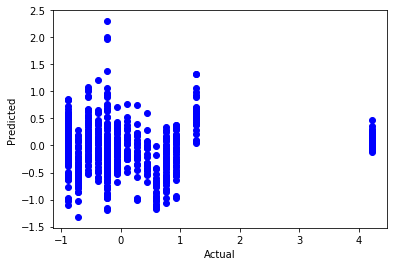

In [12]:
import matplotlib.pyplot as plt

plt.scatter(maskedlabels, pred_y, color='b')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.savefig(output_dir + '/scatter_pred_actual_' + analysis + '.png', transparent=True)
plt.show()

MAPDB:

overall: prediction accuracy: -0.0684 / p-value: 0.066543

irr_neg: prediction accuracy: -0.0570 / p-value: 0.379246

irr_pos: prediction accuracy: -0.0880 / p-value: 0.174417

irr_neu: prediction accuracy: -0.0406 / p-value: 0.531449

CBQ

overall: prediction accuracy: 0.0132 / p-value: 0.724230

CBCL

internalizing: prediction accuracy: 0.0542 / p-value: 0.146210

externalizing: prediction accuracy: -0.0040 / p-value: 0.915485

## Perform binary support vector classification

In [ ]:
if type_svm == 'binary':
    # Perform the support vector classification
    from nilearn.input_data import NiftiMasker
    from sklearn.svm import SVC
    from sklearn.feature_selection import SelectPercentile, f_classif
    from sklearn.pipeline import Pipeline

    # Set up the support vector classifier
    svc = SVC(kernel='linear')
    masker = NiftiMasker(mask_img=standard_mask,standardize=True, 
                         memory='nilearn_cache', memory_level=1)
    feature_selection = SelectPercentile(f_classif, percentile=5)
    anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])

    # Run the classifier
    X = masker.fit_transform(bold_feature_data)
    X = X[mask]
    maskedlabels=labels[mask]
    anova_svc.fit(X, maskedlabels)
    y_pred = anova_svc.predict(X)

    # Obtain prediction values via cross validation
    from sklearn.model_selection import cross_val_score, LeaveOneGroupOut

    loso = LeaveOneGroupOut()
    cv_scores = cross_val_score(anova_svc, X, maskedlabels, 
                                groups=conditions['subject'][mask], cv=loso)
    classification_accuracy = cv_scores.mean()

    print("Classification accuracy: %.4f / Chance level: %f" % 
          (classification_accuracy, 1. / len(labels.unique())))

    #results_file.write("Classification accuracy: %.4f / Chance level: %f \n" % (classification_accuracy, 1. / len(labels.unique())))

Save the SVM weights as niftis to ease in visualization.

In [ ]:
coef = svc.coef_
# reverse feature selection
coef = feature_selection.inverse_transform(coef)
# reverse masking
weight_img = masker.inverse_transform(coef)
weight_img.to_filename(output_dir + '/svmweights_'+ analysis +'.nii.gz')

In [ ]:
# compute and display a confusion matrix
from sklearn.metrics import confusion_matrix
from numpy import set_printoptions

cnf_matrix = confusion_matrix(maskedlabels, y_pred)
set_printoptions(precision=2)
classes = maskedlabels.unique()

def plot_confusion_matrix(cm, classes):
    from numpy import arange
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],  'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cnf_matrix, classes)
plt.show()

## Perform permutation testing to get a p-value for the classifier

In [ ]:
from sklearn.model_selection import permutation_test_score
import matplotlib.pyplot as plt
from numpy import savetxt

if type_svm == 'binary':
    model = anova_svc
elif type_svm == 'nonbinary':
    model = svr_lin

# Perform permutation testing to get a p-value
score, permutation_scores, pvalue = permutation_test_score(model, X, maskedlabels, scoring="accuracy", 
                                                           cv=loso, n_permutations=500, n_jobs=10, 
                                                           groups=conditions['subject'][mask])
savetxt(output_dir + '/permutation_scores_' + analysis + '.txt', permutation_scores)

print("Classification score %s (pvalue : %s)" % (score, pvalue))

# Save a figure of the permutation scores
plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)
plt.plot(2 * [1. / len(labels.unique())], ylim, '--k', linewidth=3, label='Luck')

plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.savefig(output_dir + '/permutation_plot_' + analysis + '.png', transparent=True)
plt.show()

# save final pval/classifier score
results_file.write("Classification score %s (pvalue : %s)" % (score, pvalue))
results_file.close()


In [ ]:
#Shelve the results
import shelve

filename = output_dir + '/' + analysis + '_shelved.out'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()